In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import os
import sys
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
from src.utils.logger import Logging
from src.nn.DVPDESolver import DVPDESolver
from src.nn.CVPDESolver import CVPDESolver
from src.nn.pde import diffusion_operator
from src.utils.plot_prediction import plt_prediction
from src.data.diffusion_dataset import u, r
import src.trainer.diffusion_train as diffusion_train
from src.nn.ClassicalSolver import ClassicalSolver
from src.data.diffusion_dataset import Sampler
from src.utils.ContourPlotter import ContourPlotter


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # for no GPUs

In [70]:
log_path = "./testing_checkpoints"
logger = Logging(log_path)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [71]:
torch.cuda.is_available()

True

## Generate Testing Dataset


In [ ]:
NUM_OF_POINTS = 10

dom_coords = torch.tensor(
    [[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]], dtype=torch.float32, device=DEVICE
)

time_ = (
    torch.linspace(dom_coords[0, 0], dom_coords[1, 0], NUM_OF_POINTS)
    .to(DEVICE)
    .unsqueeze(1)
    .to(torch.float32)
)
xfa = (
    torch.linspace(dom_coords[0, 1], dom_coords[1, 1], NUM_OF_POINTS)
    .to(DEVICE)
    .unsqueeze(1)
    .to(torch.float32)
)

yfa = (
    torch.linspace(dom_coords[0, 2], dom_coords[1, 2], NUM_OF_POINTS)
    .to(DEVICE)
    .unsqueeze(1)
    .to(torch.float32)
)

time_, xfa, yfa = torch.meshgrid(time_.squeeze(), xfa.squeeze(), yfa.squeeze())
X_star = torch.hstack(
    (
        time_.flatten().unsqueeze(1),
        xfa.flatten().unsqueeze(1),
        yfa.flatten().unsqueeze(1),
    )
).to(DEVICE)

# Load trained model


In [ ]:
model_dir = "./models/2025-02-25_17-03-12-608017"  # circ_19

In [ ]:
data = X_star

model_path = os.path.join(model_dir, "model.pth")
state = DVPDESolver.load_state(model_path)
solver = state["args"]["solver"]

if solver == "CV":
    state = CVPDESolver.load_state(model_path)
    model = CVPDESolver(state["args"], logger, data, DEVICE)

    model.preprocessor.load_state_dict(state["preprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])
    model.postprocessor.load_state_dict(state["postprocessor"])

elif solver == "Classical":
    state = ClassicalSolver.load_state(model_path)

    if "hidden_network" in state:
        from src.nn.ClassicalSolver2 import ClassicalSolver2

        state = ClassicalSolver2.load_state(model_path)
        model = ClassicalSolver2(state["args"], logger, data, DEVICE)
        model.preprocessor.load_state_dict(state["preprocessor"])
        model.hidden.load_state_dict(state["hidden_network"])
        model.postprocessor.load_state_dict(state["postprocessor"])

    else:
        from src.nn.ClassicalSolver import ClassicalSolver

        model = ClassicalSolver(state["args"], logger, data, DEVICE)
        model.preprocessor.load_state_dict(state["preprocessor"])
        model.postprocessor.load_state_dict(state["postprocessor"])

elif solver == "DV":
    state = DVPDESolver.load_state(model_path)
    model = DVPDESolver(state["args"], logger, data, DEVICE)
    model.preprocessor.load_state_dict(state["preprocessor"])
    model.postprocessor.load_state_dict(state["postprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])

else:
    raise ValueError(f"Unknown solver: {solver}")

model.logger = logger
model.logger.print(f"The settings used: {model.args}")
for key, value in model.args.items():
    model.logger.print(f"{key} : {value}")

model.logger.print(f"Totoal number of iterations : {len(state['loss_history'])}")
model.logger.print(f"The final loss : {state['loss_history'][-1]}")

model.loss_history = state["loss_history"]
model.model_path = logger.get_output_dir()


# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
model.logger.print(f"Total number of parameters: {total_params}")
shutil.copytree(
    model_dir,
    os.path.join(logger.get_output_dir(), model_dir.split("/")[-1]),
    dirs_exist_ok=True,
)

INFO:src.utils.logger:checkpoint path: self.log_path='./testing_checkpoints/2025-04-26_11-37-15-420057'
INFO:src.utils.logger:The settings used: {'batch_size': 64, 'epochs': 20000, 'lr': 0.005, 'seed': 1, 'print_every': 100, 'log_path': './checkpoints/diffusion', 'input_dim': 3, 'output_dim': 1, 'num_qubits': 5, 'hidden_dim': 50, 'num_quantum_layers': 1, 'classic_network': [3, 50, 1], 'q_ansatz': 'sim_circ_19', 'mode': 'hybrid', 'activation': 'tanh', 'shots': None, 'problem': 'diffusion', 'solver': 'Classical', 'device': 'cpu', 'method': 'None', 'cutoff_dim': 20, 'class': 'Classical', 'encoding': 'angle'}
INFO:src.utils.logger:batch_size : 64
INFO:src.utils.logger:epochs : 20000
INFO:src.utils.logger:lr : 0.005
INFO:src.utils.logger:seed : 1
INFO:src.utils.logger:print_every : 100
INFO:src.utils.logger:log_path : ./checkpoints/diffusion
INFO:src.utils.logger:input_dim : 3
INFO:src.utils.logger:output_dim : 1
INFO:src.utils.logger:num_qubits : 5
INFO:src.utils.logger:hidden_dim : 50
INF

Model state loaded from ./models/2025-02-25_17-03-12-608017/model.pth
Model state loaded from ./models/2025-02-25_17-03-12-608017/model.pth
Model state loaded from ./models/2025-02-25_17-03-12-608017/model.pth


'./testing_checkpoints/2025-04-26_11-37-15-420057/2025-02-25_17-03-12-608017'

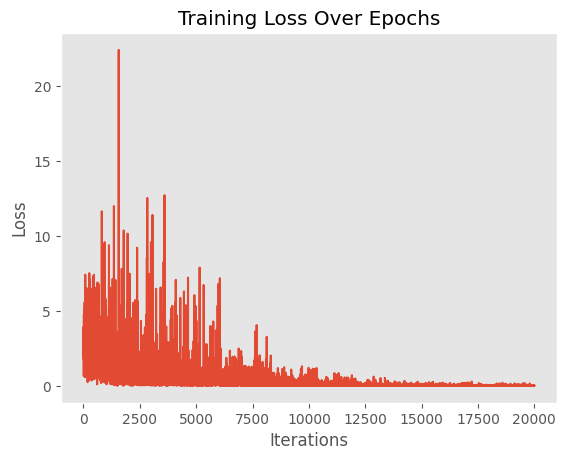

In [75]:
n = len(model.loss_history)  # Number of last iterations to plot
plt.plot(range(len(model.loss_history[-n:])), model.loss_history[-n:])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)

In [ ]:
u_pred, f_pred = diffusion_operator(
    model, X_star[:, 0:1], X_star[:, 1:2], X_star[:, 2:3]
)
if u_pred.is_cuda:
    u_pred = u_pred.cpu()
    f_pred = f_pred.cpu()


u_pred = u_pred.detach().numpy()
f_pred = f_pred.detach().numpy()

# Exact solution
u_analytic = u(X_star).cpu().detach().numpy()
f_analytic = r(X_star).cpu().detach().numpy()

error_u = (
    np.linalg.norm(u_analytic - u_pred, 2) / np.linalg.norm(u_analytic, 2)
) * 100.0
error_f = (
    np.linalg.norm(f_analytic - f_pred, 2) / np.linalg.norm(f_analytic + 1e-9, 2)
) * 100.0

logger.print("Relative L2 error_u: {:.2e}".format(error_u))
logger.print("Relative L2 error_f: {:.2e}".format(error_f))

INFO:src.utils.logger:Relative L2 error_u: 2.00e+01
INFO:src.utils.logger:Relative L2 error_f: 3.11e+00


### OR Simply call the python script

```bash
python -m src.contour_plots.diffusion_hybrid_plotting
```


INFO:src.utils.logger:checkpoint path: self.log_path='testing_checkpoints/diffusion/2025-04-26_11-27-41-611315'
INFO:src.utils.logger:Total number of iterations : 20001
INFO:src.utils.logger:The final loss : 0.014096646569669247


INFO:src.utils.logger:Relative L2 error_u: 2.00e+01
INFO:src.utils.logger:Relative L2 error_f: 3.11e+00
INFO:src.utils.logger:Total number of parameters: 7901
INFO:src.utils.logger:Using DV Solver
INFO:src.utils.logger:Total number of iterations : 20001
INFO:src.utils.logger:The final loss : 0.005991735029965639
INFO:src.utils.logger:The circuit used in the study:


Model state loaded from ./models/2025-02-25_17-03-12-608017/model.pth
Model state loaded from ./models/2025-02-25_17-03-12-608017/model.pth
Model state loaded from ./models/2025-02-21_12-00-52-045180/model.pth
The circuit is saved in testing_checkpoints/diffusion/2025-04-26_11-27-41-611315


INFO:src.utils.logger:Relative L2 error_u: 1.33e+01
INFO:src.utils.logger:Relative L2 error_f: 3.34e+00
INFO:src.utils.logger:Total number of parameters: 821


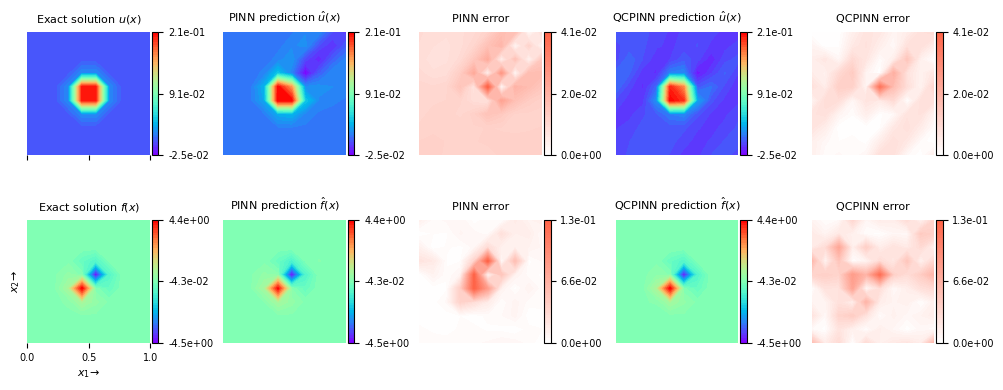


Loss values at iteration 12500:
----------------------------------------
classical           : 0.011826
angle_cascade       : 0.004480
----------------------------------------


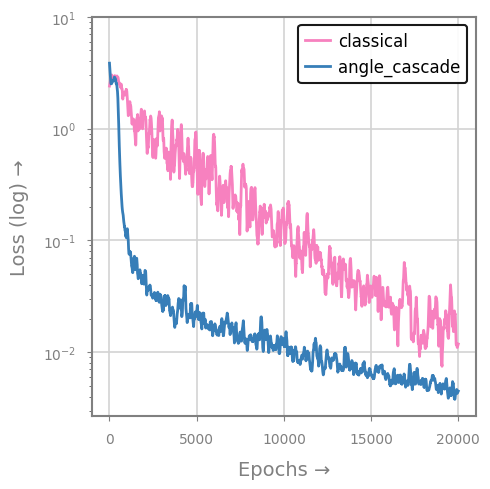

In [56]:
run -m src.contour_plots.diffusion_hybrid_plotting